# PartB: Regression Problem

In [1]:
#IMPORT
from data import readData
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
sess = tf.Session()

## 0. Read Data and Normalize

In [2]:
data = readData()
data = data / np.array((340, 120, 5, 5, 5, 10, 1, 1))

# Train Test split

In [3]:
# prepare data
# random
np.random.seed(231535622)

num_patterns = data.shape[0]
num_train_patterns = int(0.7*num_patterns)
total_indices = np.arange(num_patterns)

np.random.shuffle(total_indices)
train_indices = total_indices[:int(0.7*num_patterns)]
test_indices = total_indices[int(0.7*num_patterns):]

# 1. Build 3-layer feed forward neural network
```
Design a 3-layer feedforward neural network consists of an input layer, a hidden-layer of 10 neurons having ReLU activation functions, and a linear output layer. Use mini-batch gradient descent with a batch size=8, 𝐿2 regularization at weight decay parameter 𝛽=10−3 and a learning rate 𝛼=10−3 to train the network.
a)Use the train dataset to train the model and plot both the train and test errors against epochs.
b)State the approximate number of epochs where the test error is minimum and use it to stop training.
c)Plot the predicted values and target values for any 50 test samples
```

### Mathematical Model
```
n: number of features,
b: batch size
x: R bxn
y: R bx1

h: number of hidden neurons

hidden: R bxh = relu(x w1 + b1*)
    w1 (weight of hidden neurons): R nxh
    b1*: R bxh = 1* b1
    b1 (bias of hidden neurons): R 1xh
    1* (vector R bx1)

yp (output): R bx1 = linear(hidden w2 + b2*)
    w2 (weight of output neuron): R hx1
    b2*: R bx1 = 1* b2
    b2 (bias of output neurons): R 1x1
    1* (vector R bx1)

""" We can omit 1* in tensorflow
```

### Build Graph

In [4]:
# fixed params
n = 7 # number of features
b = 8 # batch size
h = 10 # number of hidden layer neurons
regularization_decay = 1e-3
# random
seed1 = 10
seed2 = 20
np.random.seed(seed1)
tf.random.set_random_seed(seed2)


# 3-layer 
# placeholders
x_shape = (None, n) # patterns are row vectors.
y_shape = (None, 1) # predicted values are a cell in a column vector.
x = tf.placeholder(dtype = tf.float32, shape = x_shape, name = "x")
y = tf.placeholder(dtype = tf.float32, shape = y_shape, name = "y")

# weight, biases
w1_shape = (n, h)
b1_shape = (1, h)
w1 = tf.Variable(tf.random.truncated_normal(shape = w1_shape, stddev=1.0 / np.sqrt(n), dtype=tf.float32), name='w1') # taken from start_project1b
b1 = tf.Variable(tf.random.normal(shape = b1_shape, dtype = tf.float32), name = "b1") # take arbitrary

w2_shape = (h, 1)
b2_shape = (1, 1)
w2 = tf.Variable(tf.random.truncated_normal(shape = w2_shape, stddev = 1.0 / np.sqrt(h), dtype = tf.float32), name = "w2")
b2 = tf.Variable(tf.random.normal(shape = b2_shape, dtype = tf.float32), name = "b2")

hidden = tf.nn.relu(tf.linalg.matmul(x, w1) + b1, name = "hidden")
yp = tf.identity(tf.linalg.matmul(hidden, w2) + b2, name = "yp")
#yp = tf.math.sigmoid(tf.linalg.matmul(hidden, w2) + b2, name = "yp")

# loss + L2 regularization
#loss = tf.reduce_mean(tf.math.abs(yp - y))
loss = tf.reduce_mean(tf.math.log(tf.math.cosh(yp - y)))
#loss = tf.reduce_mean(tf.math.square(yp - y))

regularization_loss = tf.reduce_mean(tf.math.square(w1)) + tf.reduce_mean(tf.math.square(w2))
total_loss = loss + regularization_decay * regularization_loss

### Train

In [5]:
# Get data
x_np = data[:, :-1]
y_np = data[:, -1:]
print(x_np.shape)
print(y_np.shape)

x_train = x_np[train_indices]
y_train = y_np[train_indices]
x_test = x_np[test_indices]
y_test = y_np[test_indices]

(400, 7)
(400, 1)


In [6]:
# hyperparams
learning_rate = 1e-3
epochs = 1000

# train op
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate)
train_op = optimizer.minimize(total_loss)

# start train
listtrain_loss = []
listtest_loss = []

sess.run(tf.global_variables_initializer())

train_loss = sess.run(loss, feed_dict = {x: x_train, y:y_train})
test_loss = sess.run(loss, feed_dict = {x: x_test, y:y_test})
print("epoch 0, train loss {}, test loss {}".format(train_loss, test_loss))

for i in range(1, epochs+1, 1):
    for minibatch in range(0, num_train_patterns, b):
        sess.run(train_op, feed_dict = {
            x: x_train[minibatch:minibatch+b, :],
            y: y_train[minibatch:minibatch+b, :],
        })
    
    # each epoch, reshuffle the trainset and record
    _indices = np.arange(num_train_patterns)
    np.random.shuffle(_indices)
    x_train = x_train[_indices]
    y_train = y_train[_indices]
    
    train_loss = sess.run(loss, feed_dict = {x: x_train, y:y_train})
    test_loss = sess.run(loss, feed_dict = {x: x_test, y:y_test})
    if (i % 100 == 0):
        print("epoch {}, train loss {}, test loss {}".format(i, train_loss, test_loss))
    listtrain_loss.append(train_loss)
    listtest_loss.append(test_loss)

epoch 0, train loss 0.027852129191160202, test loss 0.026933806017041206
epoch 100, train loss 0.007767871487885714, test loss 0.007609252352267504
epoch 200, train loss 0.005355800036340952, test loss 0.005617179907858372
epoch 300, train loss 0.004596731625497341, test loss 0.0050270105712115765
epoch 400, train loss 0.004257094115018845, test loss 0.0047638555988669395
epoch 500, train loss 0.004063654690980911, test loss 0.00460602855309844
epoch 600, train loss 0.003930571489036083, test loss 0.004490657709538937
epoch 700, train loss 0.0038276033010333776, test loss 0.004395236261188984
epoch 800, train loss 0.0037421106826514006, test loss 0.004311991855502129
epoch 900, train loss 0.00366993504576385, test loss 0.004236365202814341
epoch 1000, train loss 0.00360732339322567, test loss 0.004166735336184502


## a) Plot train errors and test errors against epochs

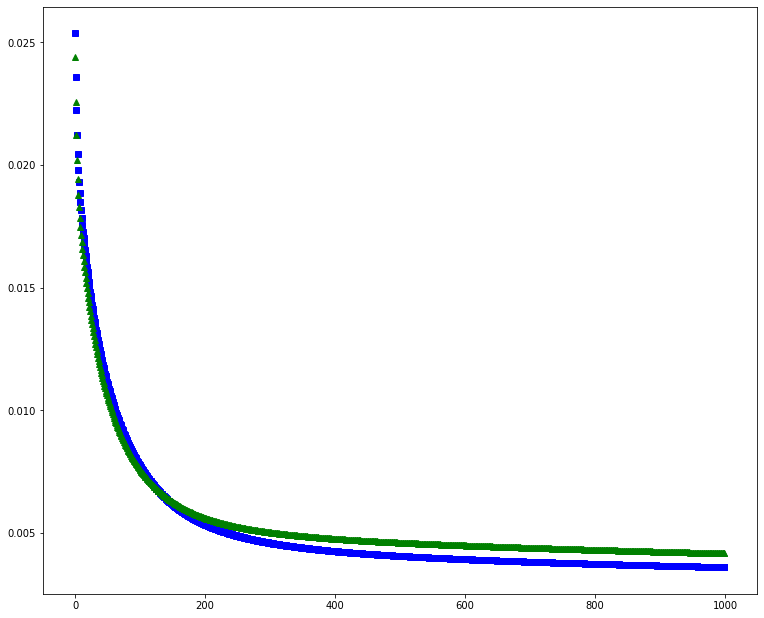

In [7]:
plt.figure(figsize = (12.8, 10.8))
plt.plot(range(epochs), listtrain_loss, "bs", range(epochs), listtest_loss, "g^")

## b) Approximate steady state
Epoch: 1000

## c) Plot the predicted values and target values for any 50 test samples

Comments:
    ...

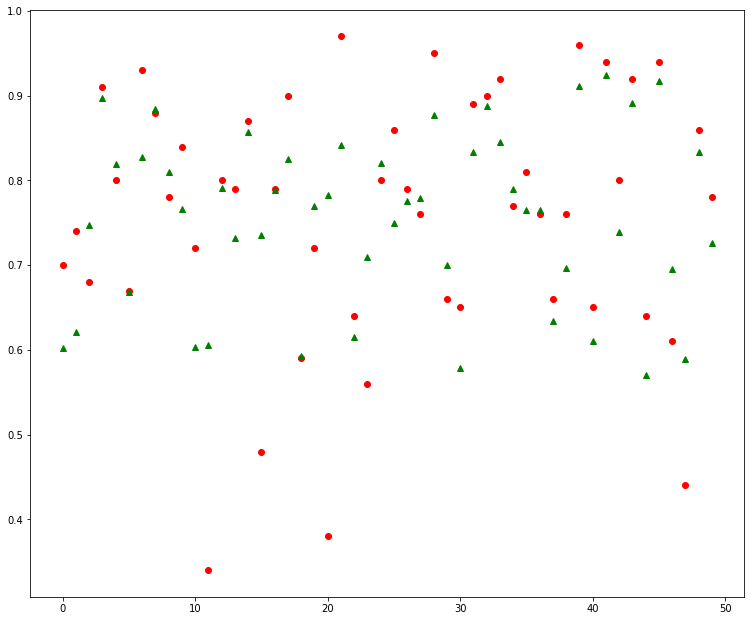

In [8]:
x_test50 = x_test[0:50, :]
y_test50 = y_test[0:50, :]

y_pred = sess.run(yp, feed_dict = {x: x_test50})
plt.figure(figsize = (12.8, 10.8))
plt.plot(range(50), y_test50, "ro", range(50), y_pred, "g^")

In [9]:
sess.close()